In [138]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F

def split_data(train_data, valid_size):
    """ Split data into training and validation dataset"""
    num_samples = len(train_data)
    indices = list(range(num_samples))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size*num_samples))
    return indices[split:], indices[:split]


def make_dataloaders(train_idx, valid_idx, train_data, test_data, batch_size, num_workers):
    """ Creates DataLoader objects for training, validation and test.
    These objects are used as iterators to go through the dataset while training."""
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                               sampler = train_sampler, num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                               sampler = valid_sampler, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers)
    return train_loader, valid_loader, test_loader


# pre-processing step
# Pytorch loads images using PIL, therefore converting them to tensors and normalizing them.
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# download the model
train_data = datasets.FashionMNIST(root='root', train=True, transform=transforms, download=True)
test_data = datasets.FashionMNIST(root='root', train=False, transform=transforms, download=True)

valid_size = 0.2
batch_size = 32
num_workers = 0

train_idx, valid_idx = split_data(train_data, valid_size)
train_loader, valid_loader, test_loader = make_dataloaders(train_idx, valid_idx,
                                                           train_data, test_data,
                                                           batch_size, num_workers)

In [139]:
# dataset information

print("Number of training images - ", int(len(train_data)*(1-valid_size)))
print("Number of validation images - ", int(len(train_data)*valid_size))
print("Number of testing images - ", len(test_data))
print("Number of batches in training set - ", len(train_loader))


Number of training images -  48000
Number of validation images -  12000
Number of testing images -  10000
Number of batches in training set -  1500


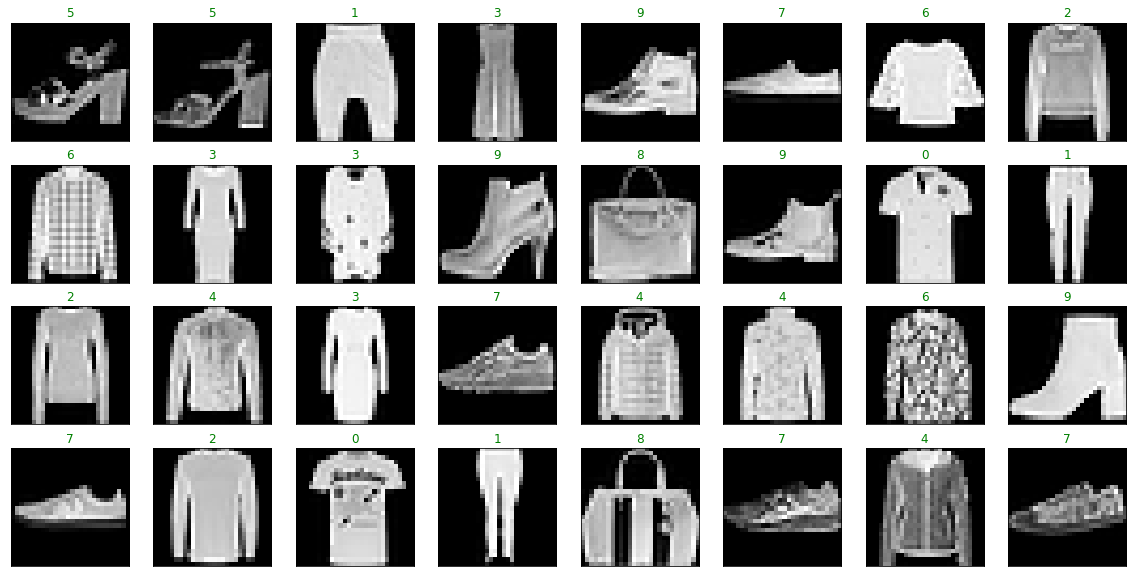

In [140]:
# visualizing the dataset

def display_image_batch(loader):
    """ Displays one batch of dataset with their labels"""
    dataiter = iter(loader)
    images, labels = dataiter.next()

    fig = plt.figure(figsize=(20, 10))
    for i in range(32):
        ax = fig.add_subplot(4, 8, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(str(labels[i].item()), color='g')

display_image_batch(train_loader)

torch.Size([1, 28, 28])


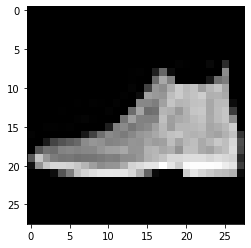

In [141]:
# image details

def image_display(loader):
    """ diplays one image """
    dataiter = iter(loader)
    images, labels = dataiter.next()
    print(images[0].shape)
    plt.imshow(images[0].numpy().squeeze(), cmap='Greys_r');

image_display(test_loader)

T-shirt/Top  -  4813
Trouser  -  4762
Pullover  -  4914
Dress  -  4668
Coat  -  4907
Sandal  -  4847
Shirt  -  4661
Sneaker  -  4750
Bag  -  4815
Ankle Boot  -  4863


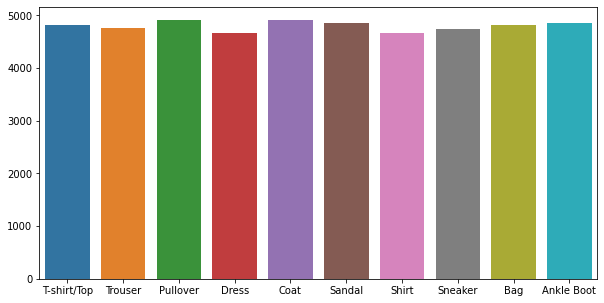

In [142]:
# class distribution

def class_distribution(loader, classes):
    """ Class distribution - number of sample per class. """
    label_dist = [0]*10
    for i in train_loader:
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        for j in labels:
            label_dist[j.item()] += 1
            
    for k in range(len(classes)):
        print(classes[k], " - ", label_dist[k])
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(classes, label_dist, ax=ax)

classes = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
class_distribution(test_loader, classes)

In [143]:
# define model

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # conv2d - i/p channels, o/p channels, num_filters
        # nn.Sequential is used to define a sequence od processes
        # which are applied to a layer
        self.layer1 = nn.Sequential(
            # padding = 1, to keep image dimensions same
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc1 = nn.Linear(128*3*3, 600)
        self.dropout = nn.Dropout(0.25)

        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        # The order of layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [144]:
def weights_init_uniform_rule(m):
    """ Weight initialisation 
    A general rule is to initialise them in the range - (-1/√n, 1/√n)
    where n is the number of inputs to the neuron"""
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

model = Net()
model.apply(weights_init_uniform_rule)
print(model)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=600, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Li

In [145]:
if torch.cuda.is_available:
    train_on_gpu = True
else:
    train_on_gpu = False

In [146]:
# transfer model to GPU
model.cuda()

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1152, out_features=600, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Li

In [147]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epochs = 10

loss_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(1, n_epochs + 1):

    ############
    # training #
    ############
    model.train()

    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()

        # forward pass
        output = model(images)
        loss = criterion(output, labels)

        # zero out the gradients in every epoch
        optimizer.zero_grad()

        # backprop
        loss.backward()
        optimizer.step()
    
    else:
        total = 0
        correct = 0

        # stops the effect of dropout layer
        model.eval()

        for images, labels in valid_loader:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()

            # labels is of dimension - [32]
            labels_list.append(labels)
            # output is of dimension - [32x10]
            output = model(images)

            # predictions is the maximum of the scores
            # (torch.max)[1] means we are accessing the labels
            # of the maximum scored class
            predictions = torch.max(output, 1)[1].to(device)

            predictions_list.append(predictions)

            # number of correct predictions
            correct += (predictions == labels).sum()

            total += len(labels)
    
        accuracy = correct * 100/total
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)

        print("Epoch: {}, Loss: {}, Accuracy: {}%".format(epoch, loss.data, accuracy))


Epoch: 1, Loss: 0.34027260541915894, Accuracy: 87%
Epoch: 2, Loss: 0.13141080737113953, Accuracy: 90%
Epoch: 3, Loss: 0.22545374929904938, Accuracy: 90%
Epoch: 4, Loss: 0.5087792873382568, Accuracy: 89%
Epoch: 5, Loss: 0.28773123025894165, Accuracy: 90%
Epoch: 6, Loss: 0.1793566197156906, Accuracy: 91%
Epoch: 7, Loss: 0.06359939277172089, Accuracy: 91%
Epoch: 8, Loss: 0.41532036662101746, Accuracy: 90%
Epoch: 9, Loss: 0.14462649822235107, Accuracy: 91%
Epoch: 10, Loss: 0.17112839221954346, Accuracy: 90%


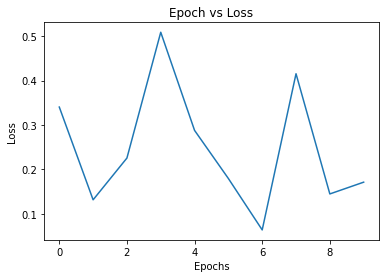

In [156]:
plt.plot(np.arange(10), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.show()

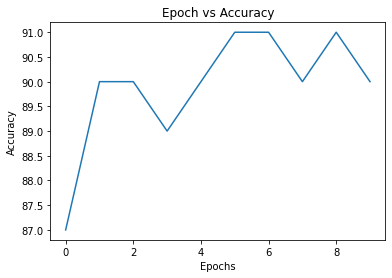

In [157]:
plt.plot(np.arange(10), accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.show()

Accuracy of T-shirt/Top: 85.38%
Accuracy of Trouser: 98.10%
Accuracy of Pullover: 83.48%
Accuracy of Dress: 85.13%
Accuracy of Coat: 89.35%
Accuracy of Sandal: 89.57%
Accuracy of Shirt: 73.31%
Accuracy of Sneaker: 96.01%
Accuracy of Bag: 97.66%
Accuracy of Ankle Boot: 98.36%


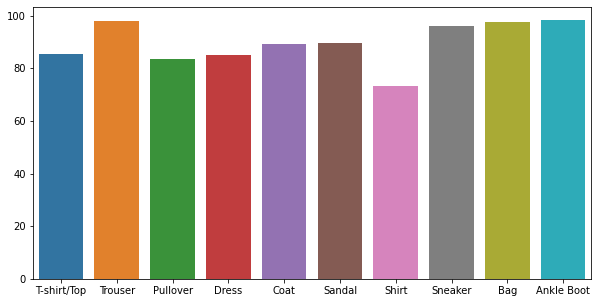

In [173]:
def class_wise_accuracies(test_loader):
    """ class-wise accuracies """
    
    class_correct = [0. for _ in range(10)]
    total_correct = [0. for _ in range(10)]

    with torch.no_grad(): # to increase computation speed
        for images, labels in test_loader:

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            c = (predicted == labels).squeeze()
            
            for i in range(10):
                label = labels[i]
                class_correct[label] += c[i].item()
                total_correct[label] += 1
            
    for i in range(10):
        print("Accuracy of {}: {:.2f}%".format(classes[i], class_correct[i] * 100 / total_correct[i]))

    new_class_list = [ (class_correct[i]*100)/total_correct[i]  for i in range(len(classes))]

    # plot of class-wise accuracies
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.barplot(classes, new_class_list, ax=ax)

class_wise_accuracies(test_loader)